# Advancing Movie Recommendations System Engine: A Novel Hybrid Approach Integrating Collaborative and Content-Based Filtering with Enhanced NLP NER and Sentiment Analysis

# Table of Contents
1.Introduction and Methodology <br>
2.Data Pre-Processing <br>
3.Exploratory Data Analysis (EDA) <br>
4.Content-Based Filtering: Genre-based, NLP NER-based, Weighted Average <br>
5.Collaborative Filtering: Using SVD, Enhanced with Sentiment Analysis<br>
6.Hybrid Recommendation System: Integrating Collaborative & Content-Based Approaches,Compilation of All Recommendation Results<br>
7.Experimentation: Collaborative Filtering using RandomForestClassifier for Sentiment Analysis<br>



# 1. Introduction & Methodology
This Jupyter Notebook documents the process of building a advanced hybrid movie recommendation system. The system integrates collaborative and content-based filtering approaches, enhanced with sentiment analysis and natural language processing. Research objective is to explore various recommendation strategies and evaluate their performance based on a sample dataset.


### Methodology
The development of this recommendation system involves several stages, each contributing uniquely to the system's overall performance:

1. **Data Pre-Processing**: Initial data cleaning, handling missing values, and data structuring for analysis.
2. **Exploratory Data Analysis (EDA)**: Gaining insights into the dataset through visual and statistical analysis to inform subsequent modeling choices.
3. **Content-Based Filtering**:
    - **Genre-based Recommendations**: Leveraging movie genres to recommend similar movies.
    - **NLP NER-based Recommendations**: Utilizing Named Entity Recognition (NER) to enhance recommendations based on entities extracted from movie titles.
    - **Weighted Average**: Combining genre and NER-based recommendations using a weighted average approach to balance the influence of both methods.
4. **Collaborative Filtering**:
    - Implementation of Singular Value Decomposition (SVD) for predicting user ratings.
    - Enhancement of SVD recommendations by incorporating sentiment analysis, aiming to reflect user sentiment in the recommendations.
5. **Hybrid Recommendation System**: Integration of collaborative and content-based filtering to harness the advantages of both approaches, further refined by sentiment analysis.
6. **Compilation of Results**: Aggregation of recommendations from various methods into a cohesive table for comparative analysis.
7. **Experimentation**: Exploration of alternative methodologies, such as employing a RandomForestClassifier for sentiment analysis, to benchmark and validate the chosen approach.
---


## 2. Data Preprocessing
In this section, code perform initial data cleaning, handle missing values, and prepare the data for EDA part and further analysis.


In [200]:
# Import required libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import gc


In [190]:
# Load the data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

### Read the dataset

In [167]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [168]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [169]:
def info(dataset, name):
  print("Dataset Name: ", name)
  print(f"Number of Rows: {dataset.shape[0]}")
  print(f"Number of Columns: {dataset.shape[1]}")
  print(f"Number of observations: {dataset.shape[0]*dataset.shape[1]}")
  print("Datatypes of all variables:")
  dataset.info()

In [170]:
info(movies, 'movies')

Dataset Name:  movies
Number of Rows: 62423
Number of Columns: 3
Number of observations: 187269
Datatypes of all variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [171]:
info(ratings, 'ratings')

Dataset Name:  ratings
Number of Rows: 25000095
Number of Columns: 4
Number of observations: 100000380
Datatypes of all variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


### **Combination of the dataset for EDA**

In [172]:
# Combine datasets for EDA
combined_data = pd.merge(movies, ratings, on='movieId')

In [173]:
info(combined_data, 'combined_data')

Dataset Name:  combined_data
Number of Rows: 25000095
Number of Columns: 6
Number of observations: 150000570
Datatypes of all variables:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000095 entries, 0 to 25000094
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     int64  
 4   rating     float64
 5   timestamp  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.3+ GB


In [202]:
combined_data.head(10)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,3.5,1227571347
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,4.0,1167582601
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,4.0,1265223970
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,18,3.0,1108273483
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,26,3.0,1280515839


### **Check for null values in the combined dataset**

In [175]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [176]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [177]:
combined_data.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [178]:
combined_data.dtypes

movieId        int64
title         object
genres        object
userId         int64
rating       float64
timestamp      int64
dtype: object

## 3. **Exploratory Data Analysis (EDA)**

In [179]:
combined_data.describe()

,movieId,userId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,2.138798e+04,8.118928e+04,3.533854e+00,1.215601e+09
std,3.919886e+04,4.679172e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,1.196000e+03,4.051000e+04,3.000000e+00,1.011747e+09
50%,2.947000e+03,8.091400e+04,3.500000e+00,1.198868e+09
75%,8.623000e+03,1.215570e+05,4.000000e+00,1.447205e+09
max,2.091710e+05,1.625410e+05,5.000000e+00,1.574328e+09


**1. Question: What is the distribution of movie ratings?**

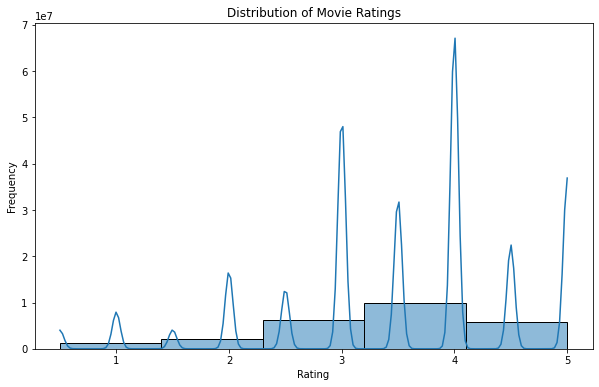

In [184]:
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['rating'], bins=5, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

**2. Question: How many movies are there in each genre?**

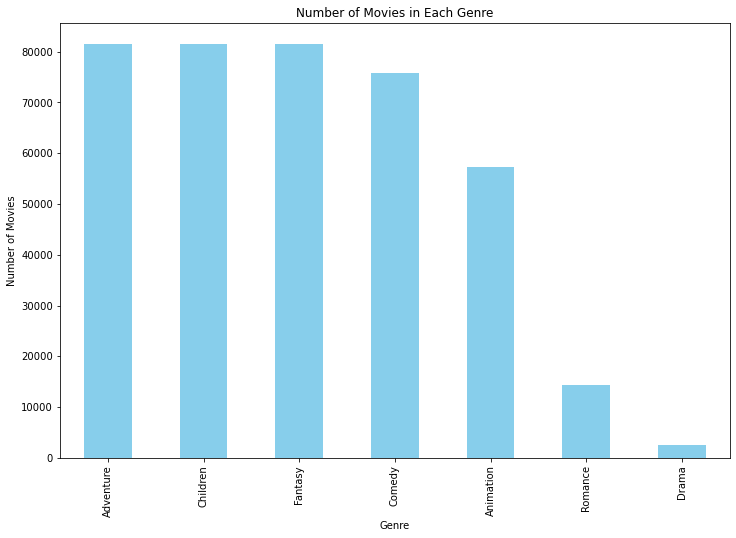

In [185]:
# Count the number of movies in each genre
genre_data = combined_data['genres'].iloc[0:100000]
genre_counts = genre_data.str.split('|', expand=True).stack().value_counts()

# Visualize the number of movies in each genre
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()

**3. Question: What are the top 10 most rated movies?**

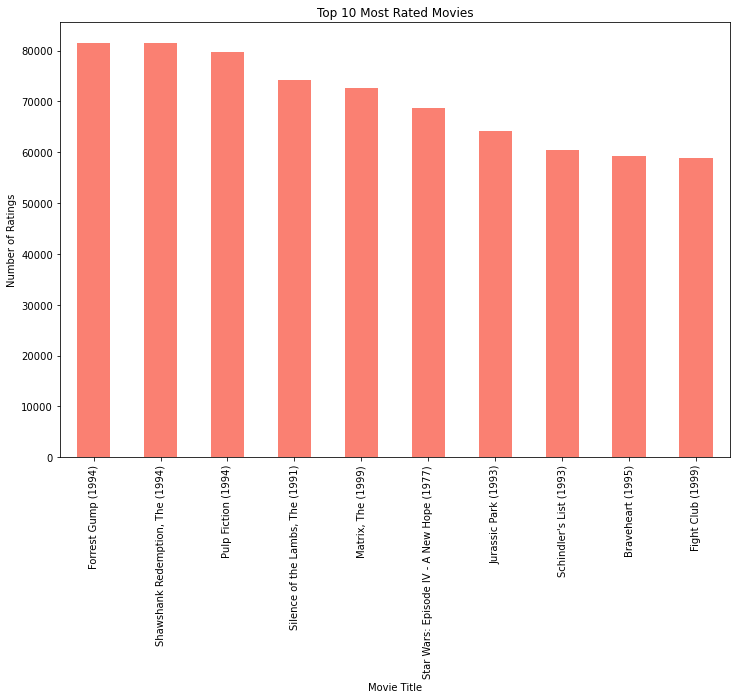

In [186]:
# Find the top 10 most rated movies
top_rated_movies = combined_data.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

# Visualize the top 10 most rated movies
plt.figure(figsize=(12, 8))
top_rated_movies.plot(kind='bar', color='salmon')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.show()

**4. How does the average rating vary with the number of ratings received by a movie?**

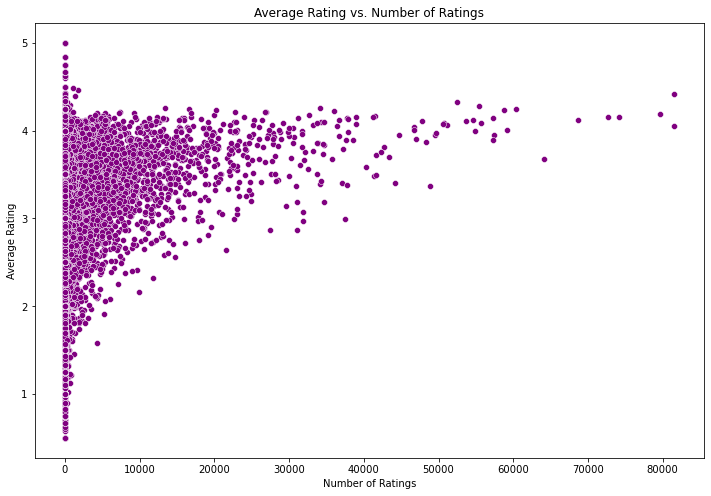

In [187]:
ratings_count = combined_data.groupby('title')['rating'].count()

avg_rating = combined_data.groupby('title')['rating'].mean()

plt.figure(figsize=(12, 8))
sns.scatterplot(x=ratings_count, y=avg_rating, color='purple')
plt.title('Average Rating vs. Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

## **4.Content-Based Filtering: Genre-based, NLP NER-based, Weighted Average**

This section delves into the mechanisms of content-based filtering, leveraging genres and Named Entity Recognition (NER) via Natural Language Processing (NLP) to curate personalized movie recommendations. The process involves two distinct strategies:

Genre-based Recommendations: This approach utilizes the genres associated with each movie to compute similarities and generate recommendations. By transforming genre labels into TF-IDF (Term Frequency-Inverse Document Frequency) features, we establish a cosine similarity matrix that serves as the basis for identifying movies with comparable genre compositions.

NER-based Recommendations: This method employs NLP to extract named entities from movie titles, providing another layer of content-based filtering. By analyzing these entities, we can uncover subtle connections between movies beyond their genre classifications.

The notebook then introduces a weighted average technique to amalgamate genre-based and NER-based recommendations, striking a balance between the two for a more nuanced recommendation list.

In [3]:
# Define function for genre-based recommendations
def content_based_recommendations_genres(movie_index, cosine_sim, n=10):
    
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Exclude self
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices][['title', 'genres']]

In [4]:
# Convert genres to TF-IDF features and calculate cosine similarity matrix
tfidf_vectorizer = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['genres'])
cosine_sim_genres = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [5]:
# Define function for NER-based recommendations
nlp = spacy.load('en_core_web_sm')  # Load SpaCy English model
def extract_named_entities(title):
    doc = nlp(title)
    return ' '.join([ent.text for ent in doc.ents])

In [6]:
# Apply NER function to the movies dataset
temp_movies = movies.copy()
temp_movies['title_entities'] = temp_movies['title'].apply(extract_named_entities)

In [7]:
# Convert named entities to TF-IDF features and calculate cosine similarity matrix
tfidf_vectorizer_entities = TfidfVectorizer()
tfidf_matrix_entities = tfidf_vectorizer_entities.fit_transform(temp_movies['title_entities'])
cosine_sim_entities = cosine_similarity(tfidf_matrix_entities, tfidf_matrix_entities)


In [8]:
# Define function to generate recommendations based on NER
def content_based_recommendations_entities(movie_index, cosine_sim, n=10):
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Exclude self
    movie_indices = [i[0] for i in sim_scores]
    return temp_movies.iloc[movie_indices][['title', 'title_entities']]

In [129]:
# Function to combine genre and NER recommendations with weights
def weighted_combined_recommendations(movie_index, cosine_sim_genres, cosine_sim_ner, movies, temp_movies, weight_genre=0.8, weight_ner=0.2, n=10):
    # Genre-based recommendations
    genre_indices = content_based_recommendations_genres(movie_index, cosine_sim_genres, n*2).index
    
    # NER-based recommendations
    ner_indices = content_based_recommendations_entities(movie_index, cosine_sim_ner, n).index
    
    # Initialize dictionary to keep track of scores
    combined_scores = {}
    
    # Assign scores based on genre similarity
    for idx in genre_indices:
        combined_scores[idx] = combined_scores.get(idx, 0) + weight_genre
    
    # Update scores based on NER similarity
    for idx in ner_indices:
        if idx in combined_scores:
            # If the movie is already recommended by genre, enhance its score
            combined_scores[idx] += weight_ner
        else:
            # If not, add it with the NER weight
            combined_scores[idx] = weight_ner
    
    # Sort movies by combined score
    sorted_scores = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Select top n movies
    top_indices = [idx for idx, score in sorted_scores[:n]]
    
    # Fetch top movies from the original movies DataFrame
    top_movies = movies.loc[top_indices]
    
    return top_movies[['movieId', 'title', 'genres']]


In [130]:
movie_index = 0  # Index of a sample movie

# Recommendations based on genres
genre_recommendations = content_based_recommendations_genres(movie_index, cosine_sim_genres)
print("Recommendations based on genres:")
print(genre_recommendations)

Recommendations based on genres:
                                                   title  \
2203                                         Antz (1998)   
3021                                  Toy Story 2 (1999)   
3653      Adventures of Rocky and Bullwinkle, The (2000)   
3912                    Emperor's New Groove, The (2000)   
4780                               Monsters, Inc. (2001)   
9949   DuckTales: The Movie - Treasure of the Lost La...   
10773                                   Wild, The (2006)   
11604                             Shrek the Third (2007)   
12969                     Tale of Despereaux, The (2008)   
17431  Asterix and the Vikings (Astérix et les Viking...   

                                            genres  
2203   Adventure|Animation|Children|Comedy|Fantasy  
3021   Adventure|Animation|Children|Comedy|Fantasy  
3653   Adventure|Animation|Children|Comedy|Fantasy  
3912   Adventure|Animation|Children|Comedy|Fantasy  
4780   Adventure|Animation|Children|Comed

In [131]:
movie_index = 0  # Index of a sample movie from the original 'movies' DataFrame

# Recommendations based on NER (using the temporary dataset)
ner_recommendations = content_based_recommendations_entities(movie_index, cosine_sim_entities)
print("Recommendations based on NER extracted from titles:")
print(ner_recommendations)

Recommendations based on NER extracted from titles:
                                         title        title_entities
24064        Toy Story That Time Forgot (2014)        Toy Story 2014
22634        Toy Story Toons: Small Fry (2011)       Toy Story Toons
24062  Toy Story Toons: Partysaurus Rex (2012)  Toy Story Toons 2012
33603                       Toy Masters (2014)      Toy Masters 2014
40614                       The Toy Box (1971)      The Toy Box 1971
24693                      The Toy Wife (1938)     The Toy Wife 1938
3                     Waiting to Exhale (1995)                  1995
5                                  Heat (1995)                  1995
15                               Casino (1995)                  1995
19                          Money Train (1995)                  1995


In [132]:
movie_index = 0  # Index of a sample movie from the original 'movies' DataFrame

# Generate weighted combined recommendations
weighted_recommendations = weighted_combined_recommendations(movie_index, cosine_sim_genres, cosine_sim_entities, movies, temp_movies, n=10)
print("Weighted combined recommendations (80% genre, 20% NER):")
for index, row in weighted_recommendations.iterrows():
    print(f"{row['title']} - Genres: {row['genres']}")

Weighted combined recommendations (80% genre, 20% NER):
Toy Story Toons: Small Fry (2011) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Antz (1998) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Toy Story 2 (1999) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Adventures of Rocky and Bullwinkle, The (2000) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Emperor's New Groove, The (2000) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Monsters, Inc. (2001) - Genres: Adventure|Animation|Children|Comedy|Fantasy
DuckTales: The Movie - Treasure of the Lost Lamp (1990) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Wild, The (2006) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Shrek the Third (2007) - Genres: Adventure|Animation|Children|Comedy|Fantasy
Tale of Despereaux, The (2008) - Genres: Adventure|Animation|Children|Comedy|Fantasy


## **5.Collaborative Filtering: Using SVD, Enhanced with Sentiment Analysis**

For collaborative filtering, we utilize Singular Value Decomposition (SVD) from the Surprise library to predict user preferences based on past interactions.

Sentiment analysis enhances this by adjusting ratings through a linear regression model, using ratings as a proxy for sentiment. This model introduces variability with a random feedback factor to simulate diverse user opinions, ensuring adjusted ratings remain within typical bounds. 

This approach combines the predictive power of SVD with sentiment insights to refine recommendations, aiming for more personalized and accurate movie suggestions

In [181]:
# Define sentiment categorization function
def categorize_sentiment(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating <= 2.0:
        return 'negative'
    else:
        return 'neutral'

In [182]:
# Apply sentiment categorization to ratings
ratings['sentiment'] = ratings['rating'].apply(categorize_sentiment)

**Question : Sentiment distribution of Movies based on Rating Classification**

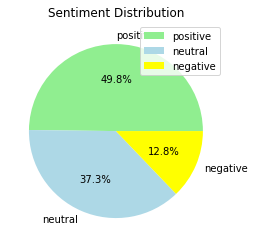

In [183]:
labels = ['positive', 'neutral', 'negative']
sizes = ratings['sentiment'].value_counts()
colors = ['lightgreen', 'lightblue', 'yellow']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors)
plt.gca().set_title('Sentiment Distribution')
plt.gca().legend(loc='upper right', labels=labels)
plt.gca().set_aspect('equal')

plt.show()

### **Collaborative Filtering with SVD using Surprise Library**

In [15]:
# Load the Surprise dataset for collaborative filtering
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [16]:
# Train the collaborative filtering model using SVD
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [17]:
# Define the SVD recommendation function
def svd_recommendations(user_id, movies, algo, n=10):
    predictions = []
    for movie_id in movies['movieId'].unique():
        prediction = algo.predict(user_id, movie_id)
        predictions.append((movie_id, prediction.est))
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movie_ids = [movie_id for movie_id, _ in predictions[:n]]
    top_recommendations = [(movies[movies['movieId'] == movie_id]['title'].iloc[0], score) for movie_id, score in predictions[:n]]
    return top_recommendations


In [110]:
# Example usage for SVD recommendation
user_id = random.randint(0, 7000)  # Random user ID for demonstration

# SVD Recommendations
top_svd_recommendations = svd_recommendations(user_id, movies, algo, n=10)
print("Top recommendations based on SVD:")
for movie_title, estimated_rating in top_svd_recommendations:
    print(f"Movie Title: {movie_title}, Estimated Rating: {estimated_rating}")

Top recommendations based on SVD:
Movie Title: Shawshank Redemption, The (1994), Estimated Rating: 5
Movie Title: Schindler's List (1993), Estimated Rating: 5
Movie Title: Civil War, The (1990), Estimated Rating: 5
Movie Title: Life (2009), Estimated Rating: 5
Movie Title: Hidden Figures (2016), Estimated Rating: 5
Movie Title: Band of Brothers (2001), Estimated Rating: 5
Movie Title: Cosmos: A Spacetime Odissey, Estimated Rating: 5
Movie Title: Pride and Prejudice (1995), Estimated Rating: 4.98502051139718
Movie Title: Singin' in the Rain (1952), Estimated Rating: 4.954540860714751
Movie Title: When Harry Met Sally... (1989), Estimated Rating: 4.946858562037452


### **SVD recommendation enhanced with Sentiment Analysis**

In an ideal scenario, sentiment analysis would be conducted on user reviews to better understand user preferences and adjust the ratings accordingly. However, due to the computational complexity and the extensive data processing required to analyze textual reviews, this research simplifies the approach by utilizing the numerical ratings data as a proxy for sentiment. This simplification allows for a more feasible implementation within the scope of this research while still exploring the impact of sentiment on recommendation systems. Train a linear regression model using ratings as a simplified representation of user sentiment. The model is trained with ratings as both features and target, acknowledging that this approach is a simplification meant to simulate sentiment adjustments in a computationally efficient manner. Later, adjusted with random factor to represent hypothetically flucatuation in user revies or sentiment.

In [191]:
# Train a linear regression model using ratings as both features and target (for simplicity)
lin_reg = LinearRegression()
ratings_features = ratings['rating'].values.reshape(-1, 1)
lin_reg.fit(ratings_features, ratings_features)

LinearRegression()

In [119]:
def adjust_rating_based_on_model(original_rating, model):
    # Introduce a dynamic feedback factor to simulate variability in user sentiment.
    # This random factor represents hypothetical fluctuations in user reviews or sentiment,
    # which, in a more complex model, would be derived from textual analysis of user reviews.
    feedback_factor = random.uniform(-0.5, 0.5)  # Randomly choose a value between -0.5 and 0.5
    
    # Use the linear model to adjust the original rating based on the simulated feedback factor.
    # This adjustment aims to reflect how actual sentiment analysis might influence the ratings,
    # thereby introducing a layer of realism to the recommendations.
    adjusted_rating = model.predict([[original_rating + feedback_factor]])[0][0]
    
    # Ensure the adjusted rating remains within the typical rating bounds of 1 to 5.
    adjusted_rating = np.clip(adjusted_rating, 1, 5)
    
    return adjusted_rating

In [193]:
def svd_recommendation_with_sentiment(user_id, movies, algo, model, n=10):
    # Generate SVD recommendations as the baseline.
    svd_recommendations = [(movie_id, algo.predict(user_id, movie_id).est) for movie_id in movies['movieId'].unique()]
    svd_recommendations.sort(key=lambda x: x[1], reverse=True)
    top_svd_recommendations = svd_recommendations[:n]
    
    # Adjust the SVD recommendations using the sentiment-adjusted ratings.
    # This step integrates the simplified sentiment model into the collaborative filtering approach,
    # aiming to enhance recommendation relevance by incorporating a form of sentiment analysis.
    adjusted_recommendations = [(movie_id, adjust_rating_based_on_model(score, model)) for movie_id, score in top_svd_recommendations]
    
    # Compile the final lists of SVD and sentiment-adjusted recommendations for comparison.
    top_svd_recommendations_titles = [(movies.loc[movies['movieId'] == movie_id, 'title'].iloc[0], score) for movie_id, score in top_svd_recommendations]
    top_adjusted_recommendations_titles = [(movies.loc[movies['movieId'] == movie_id, 'title'].iloc[0], score) for movie_id, score in adjusted_recommendations]
    
    return top_svd_recommendations_titles, top_adjusted_recommendations_titles

In [194]:
# Example usage
user_id = random.randint(1, 610)  # Assuming user IDs are between 1 and 610
top_svd_recommendations, top_adjusted_recommendations = svd_recommendation_with_sentiment(user_id, movies, algo, lin_reg, n=10)

# Print SVD Recommendations
print("Top SVD Recommendations:")
for movie_title, score in top_svd_recommendations:
    print(f"{movie_title}, Score: {score:.2f}")

print("\nTop Recommendations with Sentiment Adjustment:")
# Print Hybrid Recommendations with Sentiment Adjustment
for movie_title, adjusted_score in top_adjusted_recommendations:
    print(f"{movie_title}, Adjusted Score: {adjusted_score:.2f}")

Top SVD Recommendations:
Matrix, The (1999), Score: 4.69
Legend of the Galactic Heroes: My Conquest Is the Sea of Stars (1988), Score: 4.62
Fight Club (1999), Score: 4.59
Long Way Round (2004), Score: 4.59
Shawshank Redemption, The (1994), Score: 4.58
Jimmy Carr: In Concert (2008), Score: 4.52
Bill Burr: Why Do I Do This? (2008), Score: 4.47
Planet Earth II (2016), Score: 4.46
Planet Earth (2006), Score: 4.46
Seven (a.k.a. Se7en) (1995), Score: 4.45

Top Recommendations with Sentiment Adjustment:
Matrix, The (1999), Adjusted Score: 4.56
Legend of the Galactic Heroes: My Conquest Is the Sea of Stars (1988), Adjusted Score: 4.20
Fight Club (1999), Adjusted Score: 4.49
Long Way Round (2004), Adjusted Score: 4.62
Shawshank Redemption, The (1994), Adjusted Score: 5.00
Jimmy Carr: In Concert (2008), Adjusted Score: 4.60
Bill Burr: Why Do I Do This? (2008), Adjusted Score: 4.93
Planet Earth II (2016), Adjusted Score: 4.71
Planet Earth (2006), Adjusted Score: 4.68
Seven (a.k.a. Se7en) (1995), 

## **6.Hybrid Recommendation System: Integrating Collaborative & Content-Based Approaches,Compilation of All Recommendation Results**

In [197]:
def compile_final_recommendations(user_id, movie_idx, movies, algo, model, cosine_sim_genres, cosine_sim_entities, n=10):
    # Genre-Based Recommendations
    genre_based_results = content_based_recommendations_genres(movie_idx, cosine_sim_genres, n)
    genre_recs = genre_based_results['title'].tolist()

    # NER-Based Recommendations
    ner_based_results = content_based_recommendations_entities(movie_idx, cosine_sim_entities, n)
    ner_recs = ner_based_results['title'].tolist()

    # Weighted Genre + NER Recommendations
    weighted_recs_df = weighted_combined_recommendations(movie_idx, cosine_sim_genres, cosine_sim_entities, movies, n)
    weighted_recs = weighted_recs_df['title'].tolist()

    # SVD Recommendations
    svd_recs = [rec[0] for rec in svd_recommendations(user_id, movies, algo, n)]

    # SVD with Sentiment Adjustments
    _, svd_sentiment_recs = svd_recommendation_with_sentiment(user_id, movies, algo, model, n)

    # Generate final recommendations
    combined_final_recs = list(set(weighted_recs[:n//2] + svd_sentiment_recs[:n//2]))

    # Fill additional recommendations if needed based on final recommendation outpupt
    additional_recs_needed = n - len(combined_final_recs)
    if additional_recs_needed > 0:
        combined_final_recs.extend(weighted_recs[n//2:n//2+additional_recs_needed])

    # Populate the DataFrame
    results_df = pd.DataFrame({
        'Genre_Based': pd.Series(genre_recs, dtype=str),
        'NER_Based': pd.Series(ner_recs, dtype=str),
        'Weighted_Genre_NER': pd.Series(weighted_recs, dtype=str),
        'SVD': pd.Series(svd_recs, dtype=str),
        'SVD_Sentiment': pd.Series(svd_sentiment_recs, dtype=str),
        'Final_Hybrid': pd.Series(combined_final_recs, dtype=str)
    })

    return results_df




In [201]:
# Example usage
user_id = random.randint(1, 610)  # Random User ID from sample range
movie_idx = 0  #  the index for "Toy Story"

recommendation_results = compile_final_recommendations(user_id, movie_idx, movies, algo, lin_reg, cosine_sim_genres, cosine_sim_entities, n=10)
recommendation_results.head(10)

,Genre_Based,NER_Based,Weighted_Genre_NER,SVD,SVD_Sentiment,Final_Hybrid
0,Antz (1998),Toy Story That Time Forgot (2014),Toy Story Toons: Small Fry (2011),Law Abiding Citizen (2009),"(Law Abiding Citizen (2009), 5.0)",Toy Story Toons: Small Fry (2011)
1,Toy Story 2 (1999),Toy Story Toons: Small Fry (2011),Antz (1998),"Boondock Saints, The (2000)","(Boondock Saints, The (2000), 5.0)",Antz (1998)
2,"Adventures of Rocky and Bullwinkle, The (2000)",Toy Story Toons: Partysaurus Rex (2012),Toy Story 2 (1999),Armageddon (1998),"(Armageddon (1998), 5.0)","(""Christmas Vacation (National Lampoon's Chris..."
3,"Emperor's New Groove, The (2000)",Toy Masters (2014),"Adventures of Rocky and Bullwinkle, The (2000)",Christmas Vacation (National Lampoon's Christm...,(Christmas Vacation (National Lampoon's Christ...,"Adventures of Rocky and Bullwinkle, The (2000)"
4,"Monsters, Inc. (2001)",The Toy Box (1971),"Emperor's New Groove, The (2000)",Jim Jefferies: Fully Functional (EPIX) (2012),(Jim Jefferies: Fully Functional (EPIX) (2012)...,"('Law Abiding Citizen (2009)', 5.0)"
5,DuckTales: The Movie - Treasure of the Lost La...,The Toy Wife (1938),"Monsters, Inc. (2001)","Very Thought of You, The (1998)","(Very Thought of You, The (1998), 4.5833009809...","('Armageddon (1998)', 5.0)"
6,"Wild, The (2006)",Waiting to Exhale (1995),DuckTales: The Movie - Treasure of the Lost La...,Happy Gilmore (1996),"(Happy Gilmore (1996), 4.485678359702657)",('Jim Jefferies: Fully Functional (EPIX) (2012...
7,Shrek the Third (2007),Heat (1995),"Wild, The (2006)",Independence Day (a.k.a. ID4) (1996),"(Independence Day (a.k.a. ID4) (1996), 5.0)",Toy Story 2 (1999)
8,"Tale of Despereaux, The (2008)",Casino (1995),Shrek the Third (2007),"Hangover, The (2009)","(Hangover, The (2009), 4.810639820844037)","('Boondock Saints, The (2000)', 5.0)"
9,Asterix and the Vikings (Astérix et les Viking...,Money Train (1995),"Tale of Despereaux, The (2008)","Waterboy, The (1998)","(Waterboy, The (1998), 4.979511485855401)","Emperor's New Groove, The (2000)"


In [199]:
# Cleanup to free memory after recommendations, if necessary
gc.collect()

0

## 7.Experimentation: Collaborative Filtering using RandomForestClassifier for Sentiment Analysis

In [ ]:
# Define a function to train the RandomForestClassifier for sentiment analysis
def train_classifier_in_batches(data, batch_size=10000):
    classifier = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
    for start in range(0, data.shape[0], batch_size):
        end = start + batch_size
        batch_data = data.iloc[start:end]
        classifier.fit(batch_data[['userId', 'movieId']], batch_data['sentiment'])
    return classifier

In [18]:
# Train the classifier in batches
classifier = train_classifier_in_batches(ratings[['userId', 'movieId', 'sentiment']])

In [161]:
# Hybrid Recommendations Function
def hybrid_recommendation_with_sentiment1(user_id, movies, algo, classifier, n=10):
    svd_predictions = []
    for movie_id in movies['movieId'].unique():
        prediction = algo.predict(uid=str(user_id), iid=str(movie_id))
        svd_predictions.append((movie_id, prediction.est))
    svd_predictions.sort(key=lambda x: x[1], reverse=True)
    top_svd_movie_ids = [movie_id for movie_id, _ in svd_predictions[:n]]

    adjusted_scores = []
    for movie_id in top_svd_movie_ids:
        predicted_sentiment = classifier.predict([[user_id, movie_id]])[0]
        original_score = next(score for mid, score in svd_predictions if mid == movie_id)
        adjusted_score = original_score + 0.1 if predicted_sentiment == 'positive' else original_score - 0.1
        adjusted_scores.append((movie_id, adjusted_score))

    adjusted_scores.sort(key=lambda x: x[1], reverse=True)
    top_recommendations = [(movies[movies['movieId'] == movie_id]['title'].iloc[0], score) for movie_id, score in adjusted_scores[:n]]
    return top_recommendations



In [204]:
# Example usage
user_id = random.randint(1, 600)  # Random user ID for demonstration

# Hybrid Recommendations
top_hybrid_recommendations = hybrid_recommendation_with_sentiment1(user_id, movies, algo, classifier, n=10)
print("\nTop recommendations based on Hybrid model with sentiment adjustment:")
for movie_title, score in top_hybrid_recommendations:
    print(f"Movie Title: {movie_title}, Score: {score}")


Top recommendations based on Hybrid model with sentiment adjustment:
Movie Title: Toy Story (1995), Score: 3.433854451353085
Movie Title: Jumanji (1995), Score: 3.433854451353085
Movie Title: Grumpier Old Men (1995), Score: 3.433854451353085
Movie Title: Waiting to Exhale (1995), Score: 3.433854451353085
Movie Title: Father of the Bride Part II (1995), Score: 3.433854451353085
Movie Title: Heat (1995), Score: 3.433854451353085
Movie Title: Sabrina (1995), Score: 3.433854451353085
Movie Title: Tom and Huck (1995), Score: 3.433854451353085
Movie Title: Sudden Death (1995), Score: 3.433854451353085
Movie Title: GoldenEye (1995), Score: 3.433854451353085


In [205]:
# Example usage
user_id = random.randint(700, 7000)  # Random user ID for demonstration

# Hybrid Recommendations
top_hybrid_recommendations = hybrid_recommendation_with_sentiment1(user_id, movies, algo, classifier, n=10)
print("\nTop recommendations based on Hybrid model with sentiment adjustment:")
for movie_title, score in top_hybrid_recommendations:
    print(f"Movie Title: {movie_title}, Score: {score}")


Top recommendations based on Hybrid model with sentiment adjustment:
Movie Title: Toy Story (1995), Score: 3.433854451353085
Movie Title: Jumanji (1995), Score: 3.433854451353085
Movie Title: Grumpier Old Men (1995), Score: 3.433854451353085
Movie Title: Waiting to Exhale (1995), Score: 3.433854451353085
Movie Title: Father of the Bride Part II (1995), Score: 3.433854451353085
Movie Title: Heat (1995), Score: 3.433854451353085
Movie Title: Sabrina (1995), Score: 3.433854451353085
Movie Title: Tom and Huck (1995), Score: 3.433854451353085
Movie Title: Sudden Death (1995), Score: 3.433854451353085
Movie Title: GoldenEye (1995), Score: 3.433854451353085
